ValueError: 'c' argument has 1911 elements, which is inconsistent with 'x' and 'y' with size 1932.

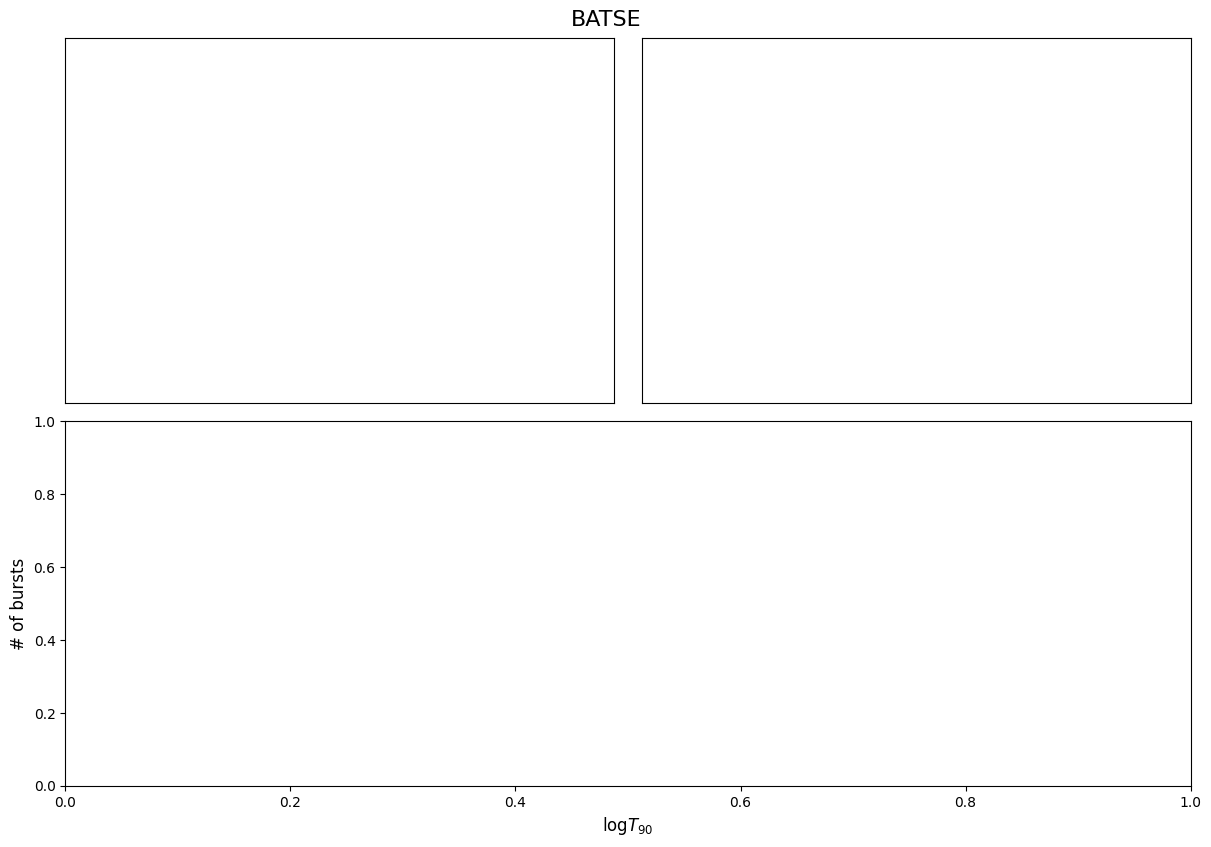

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipynb.fs.full.config_BATSE import conf
# This is to prevent a trivial warning pop-up
import warnings
warnings.filterwarnings('ignore')
emb = pd.read_csv("embedding_TSNE_BATSE.csv", header = None).set_index(0).loc[conf['color'][0].index]
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Dark2.colors)

fig = plt.figure(figsize=(12,12), constrained_layout=True)
fig.suptitle('BATSE', size=16)
gs = fig.add_gridspec(3, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1,:])
#fig, [ax1, ax2] = plt.subplots(2, sharex=True, conf['figsize'])
ax1.set(xticks=(), yticks=())
ax2.set(xticks=(), yticks=())
ax3.set_xlabel('log$T_{90}$', size=12)
ax3.set_ylabel('# of bursts', size=12)
#ax1.set(yticks=(), xticks=(), title='t-SNE')
#ax2.set(yticks=(), xticks=())

emb_plot = ax1.scatter(emb[1], emb[2], s=10, c=conf['color'][0], cmap=conf['cmap'])#, vmax = 10) # for hardness, set vmax = 10
ax2.scatter(emb[1], emb[2], s=10, c=conf['color'][1], cmap=conf['cmap'])

classification = pd.read_csv('DataFrames/classification_BATSE.txt', index_col=0)
duration_data = pd.read_pickle('DataFrames/duration_data_BATSE.dat')
group = classification.groupby(classification.type)
short = group.get_group('S')
long = group.get_group('L')
ax3.hist(np.log10(duration_data.loc[short.index,'T90']), range = (-3,3), bins = 25, color = 'C1', edgecolor = 'C1', alpha = 0.5)
ax3.hist(np.log10(duration_data.loc[long.index,'T90']), range = (-3,3), bins = 25, color = 'C2', edgecolor = 'C2', alpha = 0.5)
ax3.set_xlabel('log$T_{90}$')

cbar = plt.colorbar(emb_plot, None, ax1, location = 'left', pad = -0.08)#, aspect = 30, pad = 0.01)
cbar.set_label('log$T_{90}$', size=12)



fig.savefig("GRB-TSNE-BATSE.jpg", dpi=300)
fig.show()

In [2]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, MultiChoice, CustomJS, ColumnDataSource, LinearColorMapper, CategoricalColorMapper, ColorBar
from bokeh.layouts import column
from bokeh.palettes import Plasma256
output_notebook()

Loading BokehJS ...

In [3]:
#formatting the data as a CDS
color = conf['color'][0]
imgs = []
for trigger in emb.index.tolist():
    imgs.append(f'https://raw.githubusercontent.com/WJLM308/batse_images/main/GRB{trigger}.jpg')
try:
    color_mapper = LinearColorMapper(palette=Plasma256, low=min(color), high=max(color))
except:
    color_mapper = CategoricalColorMapper(palette=["mediumpurple", "darkorange"], factors=["C4", "C1"])
source = ColumnDataSource({'names': emb.index.tolist(), 'x': emb[1].tolist(), 'y': emb[2].tolist(), 'color': color, 'imgs': imgs})

In [4]:
plot = figure(title='t-SNE projection of the BATSE catalog of GRBs', plot_width=800, plot_height=600, tools="pan,wheel_zoom,box_zoom,lasso_select,reset")
plot.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img
            src="@imgs" height="200" alt="@imgs" width="300"
        ></img>
    </div>
    <div>
        <span><pre>@names</pre></span>
    </div>
</div>
"""))
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8)
plot.add_layout(color_bar, 'above')
plot.scatter(x = 'x', y = 'y', source = source, color={'field': 'color', 'transform': color_mapper})
multi_choice = MultiChoice(options=emb.index.astype(str).tolist())
update_highlights = CustomJS(args=dict(source=source), code="""
    source.selected['indices'] = []
    for(var i = 0; i < source.get_length(); i++) {
        //console.log(i, source.data['names'][i], cb_obj.value)
        if (cb_obj.value.includes(source.data['names'][i])) {
            source.selected['indices'].push(i)
        }
    }
    source.change.emit()
""")
selected_indices = []
multi_choice.js_on_change('value', update_highlights)
callback = CustomJS(args=dict(source=source), code="""
    //console.log('Running CustomJS callback now.');
    var indices = source.selected.indices;
    var kernel = IPython.notebook.kernel;
    kernel.execute("selected_indices = " + indices)
""")
plot.js_on_event('selectiongeometry', callback)

In [5]:
show(column(multi_choice,plot))

In [6]:
selected = emb.reset_index().isin(emb.iloc[list(selected_indices)].index)['index'].replace({False: 'L', True: 'S'})
df = pd.concat([pd.Series(emb.index), selected], axis = 1, ignore_index = True).rename({0: 'GRBname', 1: 'type'}, axis=1).set_index('GRBname')
print(df.loc[df.type=='S'])
print(df.loc[df.type=='L'])
print(len(df))
#df.to_csv('DataFrames/classification_BATSE.txt')

Empty DataFrame
Columns: [type]
Index: []
        type
GRBname     
1009       L
1025       L
1036       L
1039       L
1042       L
...      ...
942        L
946        L
973        L
974        L
999        L

[1911 rows x 1 columns]
1911


In [7]:
duration_data = pd.read_pickle('DataFrames/duration_data_BATSE.dat')
group = df.groupby(df.type)
short = group.get_group('S')
long = group.get_group('L')
plt.hist(np.log10(duration_data.loc[short.index,'T90']), bins = 25, color = 'C1', edgecolor = 'C1', alpha = 0.5)
plt.hist(np.log10(duration_data.loc[long.index,'T90']), bins = 25, color = 'C2', edgecolor = 'C2', alpha = 0.5)
plt.xlabel('log$T_{90}$', size = 12)

KeyError: 'S'